<a href="https://colab.research.google.com/github/amanjain252002/Stock-Price-Prediction/blob/main/Deep_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import ConvLSTM2D

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [103]:
AAPL = pd.read_csv("/Pre_Processed_AAPL.csv")
TSLA = pd.read_csv("/Pre_Processed_TSLA.csv")
GOOG = pd.read_csv("/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("/Pre_Processed_MSFT.csv")
AMZN = pd.read_csv("/Pre_Processed_AMZN.csv")

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Proprocessing

In [105]:
def Dataset(Data, Date):

  Train_Data = Data['Adj. Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj. Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [139]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dropout(0.1, ),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dropout(0.1, ),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dropout(0.1, ),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [140]:
model = Model()

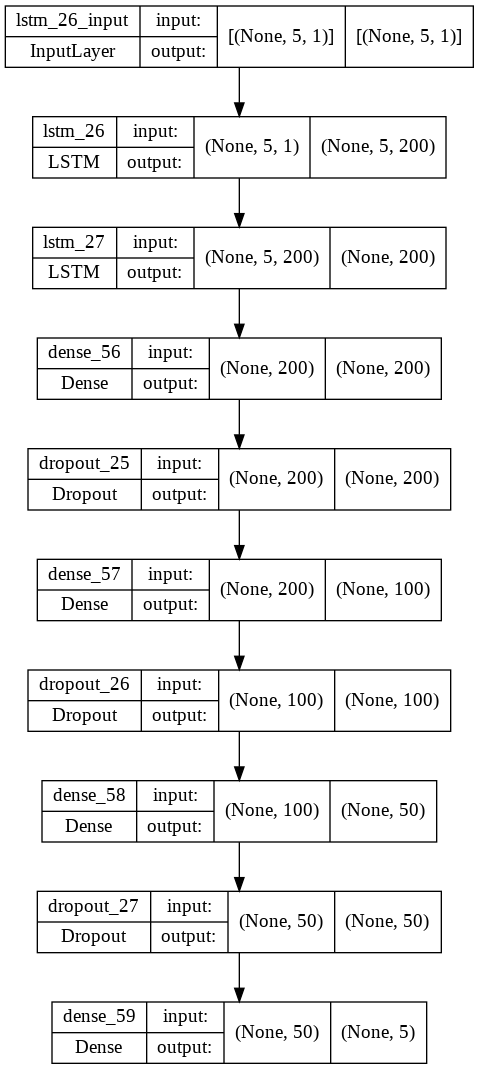

In [141]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [142]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 5, 200)            161600    
                                                                 
 lstm_27 (LSTM)              (None, 200)               320800    
                                                                 
 dense_56 (Dense)            (None, 200)               40200     
                                                                 
 dropout_25 (Dropout)        (None, 200)               0         
                                                                 
 dense_57 (Dense)            (None, 100)               20100     
                                                                 
 dropout_26 (Dropout)        (None, 100)               0         
                                                                 
 dense_58 (Dense)            (None, 50)              

### Custom Learning Rate

In [143]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

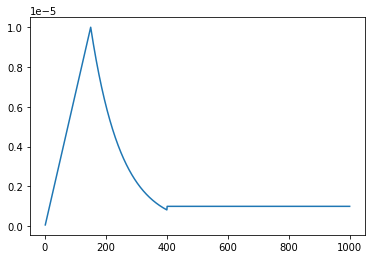

In [144]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [145]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Apple

In [146]:
AAPL.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [147]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[ns]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.8 KB


In [148]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [149]:
AAPL_Date = '2020-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

### Model Fitting

In [150]:
AAPL_Model = Model()

In [152]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [153]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 1000, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 2s 79ms/step - loss: 2313.4441 - root_mean_squared_error: 48.0983 - val_loss: 15784.5605 - val_root_mean_squared_error: 125.6366 - lr: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 33ms/step - loss: 2312.9912 - root_mean_squared_error: 48.0936 - val_loss: 15784.4443 - val_root_mean_squared_error: 125.6362 - lr: 6.6667e-08
Epoch 3/1000
9/9 [==============================] - 0s 32ms/step - loss: 2312.8611 - root_mean_squared_error: 48.0922 - val_loss: 15784.2109 - val_root_mean_squared_error: 125.6352 - lr: 1.3333e-07
Epoch 4/1000
9/9 [==============================] - 0s 36ms/step - loss: 2313.3740 - root_mean_squared_error: 48.0975 - val_loss: 15783.8467 - val_root_mean_squared_error: 125.6338 - lr: 2.0000e-07
Epoch 5/1000
9/9 [==============================] - 0s 32ms/step - loss: 2312.4761 - root_mean_squared_error: 48.0882 - val_loss: 15783.3818 - val_root_mean_squared_error: 125.6319 - lr: 2.6667e-07
Epoch 6/10

In [154]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

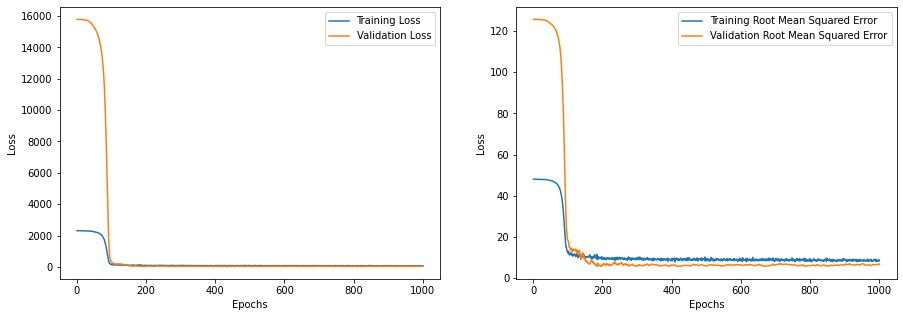

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [156]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X)

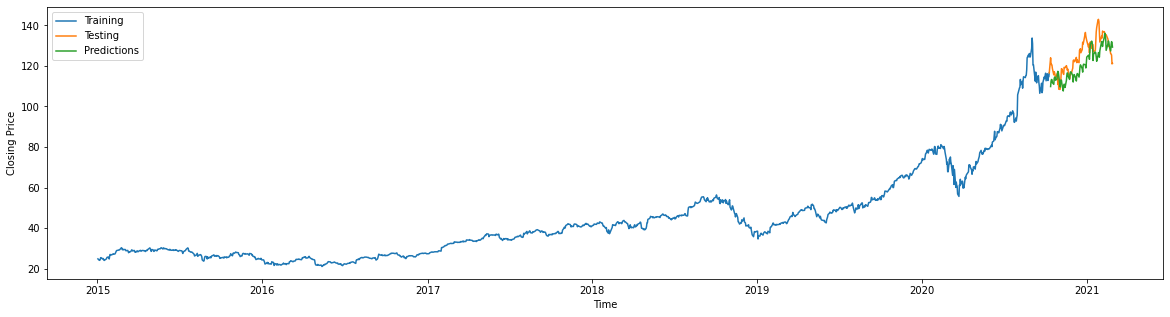

In [157]:
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < '2020-10-12'], AAPL['Adj. Close'][AAPL['Date'] < '2020-10-12'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-09'], AAPL['Adj. Close'][AAPL['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-12'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [158]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 6.821112471487236
MAPE: 0.044252173010435006


#Tesla

In [159]:
TSLA.head()
TSLA.dropna()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,44.57,44.65,42.65,43.86,43.86,23822000.0
1,2015-01-05,42.91,43.30,41.43,42.02,42.02,26842500.0
2,2015-01-06,42.01,42.84,40.84,42.26,42.26,31309500.0
3,2015-01-07,42.67,42.96,41.96,42.19,42.19,14842000.0
4,2015-01-08,42.56,42.76,42.00,42.12,42.12,17212500.0
...,...,...,...,...,...,...,...
1544,2021-02-22,762.64,768.50,710.20,714.50,714.50,37011700.0
1545,2021-02-23,662.13,713.61,619.00,698.84,698.84,66397000.0
1546,2021-02-24,711.85,745.00,694.17,742.02,742.02,36677100.0
1547,2021-02-25,726.15,737.21,670.58,682.22,682.22,38619900.0


In [160]:
TSLA.isna()
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [161]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [162]:
TSLA_Date = '2020-10-01'
TSLA_Train_X, TSLA_Train_Y, TSLA_Test_X, TSLA_Test_Y = Dataset(TSLA, TSLA_Date)

### Model Fitting

In [163]:
TSLA_Model = Model()

In [164]:
TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [165]:
TSLA_hist = TSLA_Model.fit(TSLA_Train_X, TSLA_Train_Y, epochs = 200, validation_data = (TSLA_Test_X, TSLA_Test_Y), callbacks=[callback])

Epoch 1/200
9/9 [==============================] - 2s 77ms/step - loss: 9962.0938 - root_mean_squared_error: 99.8103 - val_loss: 424206.3750 - val_root_mean_squared_error: 651.3113 - lr: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 0s 31ms/step - loss: 9947.8193 - root_mean_squared_error: 99.7388 - val_loss: 424194.9062 - val_root_mean_squared_error: 651.3025 - lr: 6.6667e-08
Epoch 3/200
9/9 [==============================] - 0s 33ms/step - loss: 9951.0898 - root_mean_squared_error: 99.7551 - val_loss: 424173.6875 - val_root_mean_squared_error: 651.2862 - lr: 1.3333e-07
Epoch 4/200
9/9 [==============================] - 0s 33ms/step - loss: 9981.6797 - root_mean_squared_error: 99.9084 - val_loss: 424138.8438 - val_root_mean_squared_error: 651.2595 - lr: 2.0000e-07
Epoch 5/200
9/9 [==============================] - 0s 32ms/step - loss: 9935.5879 - root_mean_squared_error: 99.6774 - val_loss: 424088.8750 - val_root_mean_squared_error: 651.2211 - lr: 2.6667e-07
Epoch 6/20

In [166]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

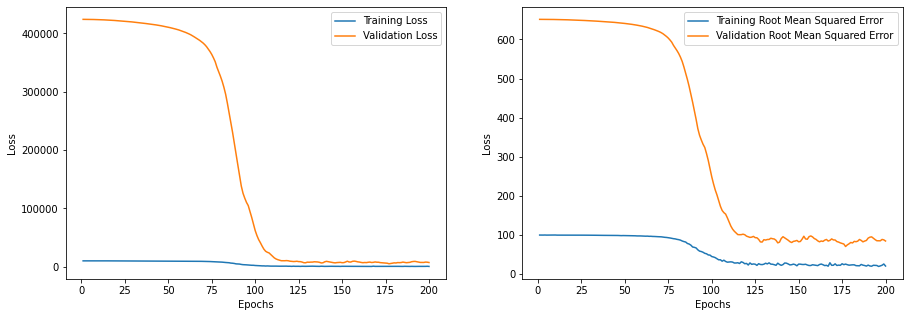

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Tesla

In [168]:
TSLA_prediction = TSLA_Model.predict(TSLA_Test_X)

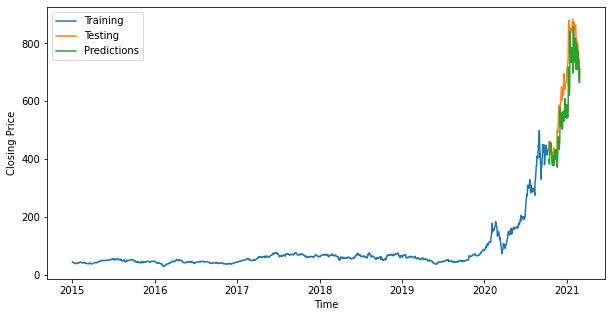

In [169]:
plt.figure(figsize=(10, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < '2020-10-12'], TSLA['Adj. Close'][TSLA['Date'] < '2020-10-12'], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-09'], TSLA['Adj. Close'][TSLA['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-12'], TSLA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [170]:
np.all(np.isnan(TSLA_Test_Y))

False

In [171]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Y.reshape(-1, 5), TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Test_Y.reshape(-1, 5))/np.abs(TSLA_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 84.56528637498138
MAPE: 0.10225924200973889


#Google

In [172]:
GOOG.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,527.56,529.82,522.67,523.37,523.37,1447563.0
1,2015-01-05,521.83,522.89,511.66,512.46,512.46,2059840.0
2,2015-01-06,513.59,514.76,499.68,500.59,500.59,2899940.0
3,2015-01-07,505.61,505.86,498.28,499.73,499.73,2065054.0
4,2015-01-08,496.63,502.10,489.66,501.30,501.30,3353582.0


In [173]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [174]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [175]:
GOOG_Date = '2020-11-01'
GOOG_Train_X, GOOG_Train_Y, GOOG_Test_X, GOOG_Test_Y = Dataset(GOOG, GOOG_Date)

### Model Fitting

In [176]:
GOOG_Model = Model()

In [177]:
GOOG_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [178]:
GOOG_hist = GOOG_Model.fit(GOOG_Train_X, GOOG_Train_Y, epochs = 1000, validation_data = (GOOG_Test_X, GOOG_Test_Y), callbacks = [callback])

Epoch 1/1000
10/10 [==============================] - 3s 71ms/step - loss: 1052059.7500 - root_mean_squared_error: 1025.6996 - val_loss: 3454708.2500 - val_root_mean_squared_error: 1858.6846 - lr: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 0s 32ms/step - loss: 1052488.7500 - root_mean_squared_error: 1025.9087 - val_loss: 3454628.7500 - val_root_mean_squared_error: 1858.6632 - lr: 6.6667e-08
Epoch 3/1000
10/10 [==============================] - 0s 31ms/step - loss: 1051936.8750 - root_mean_squared_error: 1025.6398 - val_loss: 3454472.0000 - val_root_mean_squared_error: 1858.6210 - lr: 1.3333e-07
Epoch 4/1000
10/10 [==============================] - 0s 33ms/step - loss: 1051380.2500 - root_mean_squared_error: 1025.3683 - val_loss: 3454216.0000 - val_root_mean_squared_error: 1858.5521 - lr: 2.0000e-07
Epoch 5/1000
10/10 [==============================] - 0s 30ms/step - loss: 1051850.8750 - root_mean_squared_error: 1025.5978 - val_loss: 3453885.7500 - val_root_mean_sq

In [179]:
history_dict = GOOG_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

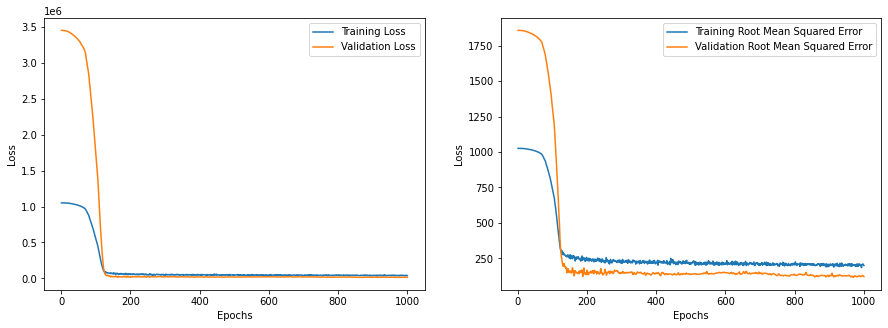

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Google

In [181]:
GOOG_prediction = GOOG_Model.predict(GOOG_Test_X)

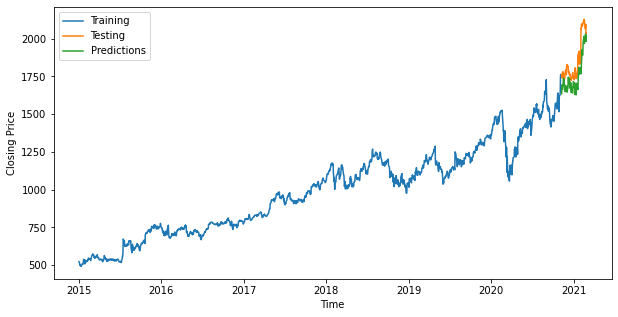

In [182]:
plt.figure(figsize=(10, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] < '2020-11-07'], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [183]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Y.reshape(-1, 5), GOOG_prediction))
mape = np.mean(np.abs(GOOG_prediction - GOOG_Test_Y.reshape(-1, 5))/np.abs(GOOG_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 121.07615271386067
MAPE: 0.055411147501772645


#Microsoft

In [184]:
MSFT.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,46.66,47.42,46.54,46.76,41.44,27913900.0
1,2015-01-05,46.37,46.73,46.25,46.33,41.06,39673900.0
2,2015-01-06,46.38,46.75,45.54,45.65,40.46,36447900.0
3,2015-01-07,45.98,46.46,45.49,46.23,40.97,29114100.0
4,2015-01-08,46.75,47.75,46.72,47.59,42.18,29645200.0


In [185]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [186]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [187]:
MSFT_Date = '2020-10-01'
MSFT_Train_X, MSFT_Train_Y, MSFT_Test_X, MSFT_Test_Y = Dataset(MSFT, MSFT_Date)

### Model Fitting

In [188]:
MSFT_Model = Model()

In [189]:
MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [190]:
MSFT_hist = MSFT_Model.fit(MSFT_Train_X, MSFT_Train_Y, epochs = 1000, validation_data = (MSFT_Test_X, MSFT_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 3s 78ms/step - loss: 10360.1836 - root_mean_squared_error: 101.7850 - val_loss: 47620.7695 - val_root_mean_squared_error: 218.2218 - lr: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 32ms/step - loss: 10368.4795 - root_mean_squared_error: 101.8257 - val_loss: 47619.1445 - val_root_mean_squared_error: 218.2181 - lr: 6.6667e-08
Epoch 3/1000
9/9 [==============================] - 0s 33ms/step - loss: 10355.8574 - root_mean_squared_error: 101.7637 - val_loss: 47615.9141 - val_root_mean_squared_error: 218.2107 - lr: 1.3333e-07
Epoch 4/1000
9/9 [==============================] - 0s 30ms/step - loss: 10376.0967 - root_mean_squared_error: 101.8631 - val_loss: 47611.2656 - val_root_mean_squared_error: 218.2001 - lr: 2.0000e-07
Epoch 5/1000
9/9 [==============================] - 0s 32ms/step - loss: 10362.6182 - root_mean_squared_error: 101.7969 - val_loss: 47605.0664 - val_root_mean_squared_error: 218.1859 - lr: 2.6667e-07


In [191]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

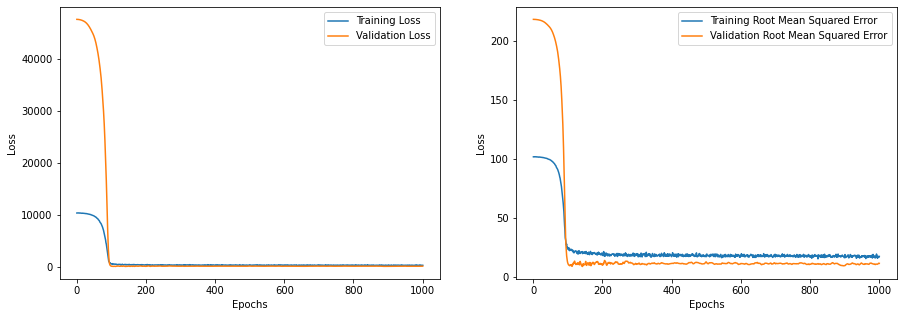

In [192]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Microsoft

In [193]:
MSFT_prediction = MSFT_Model.predict(MSFT_Test_X)

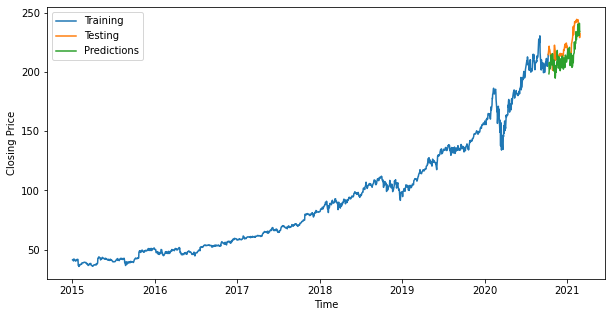

In [194]:
plt.figure(figsize=(10, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < '2020-10-12'], MSFT['Adj. Close'][MSFT['Date'] < '2020-10-12'], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-09'], MSFT['Adj. Close'][MSFT['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-12'], MSFT_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [195]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Y.reshape(-1, 5), MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Test_Y.reshape(-1, 5))/np.abs(MSFT_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 11.563906386525222
MAPE: 0.043293784503142425


#Amazon

In [208]:
AMZN.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200.0
1,2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200.0
2,2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000.0
3,2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300.0
4,2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400.0


In [209]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[ns]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.8 KB


In [210]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [211]:
AMZN_Date = '2020-11-01'
AMZN_Train_X, AMZN_Train_Y, AMZN_Test_X, AMZN_Test_Y = Dataset(AMZN, AMZN_Date)

### Model Fitting

In [212]:
AMZN_Model = Model()

In [213]:
AMZN_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [220]:
AMZN_hist = AMZN_Model.fit(AMZN_Train_X, AMZN_Train_Y, epochs = 1000, validation_data = (AMZN_Test_X, AMZN_Test_Y), callbacks=[callback])

Epoch 1/1000
10/10 [==============================] - 1s 65ms/step - loss: 96579.2188 - root_mean_squared_error: 310.7720 - val_loss: 19246.1836 - val_root_mean_squared_error: 138.7306 - lr: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 1s 60ms/step - loss: 82426.6797 - root_mean_squared_error: 287.1005 - val_loss: 19231.3398 - val_root_mean_squared_error: 138.6771 - lr: 6.6667e-08
Epoch 3/1000
10/10 [==============================] - 1s 58ms/step - loss: 88140.8203 - root_mean_squared_error: 296.8852 - val_loss: 19239.5293 - val_root_mean_squared_error: 138.7066 - lr: 1.3333e-07
Epoch 4/1000
10/10 [==============================] - 1s 63ms/step - loss: 91198.2812 - root_mean_squared_error: 301.9905 - val_loss: 19220.9980 - val_root_mean_squared_error: 138.6398 - lr: 2.0000e-07
Epoch 5/1000
10/10 [==============================] - 1s 55ms/step - loss: 97750.1094 - root_mean_squared_error: 312.6501 - val_loss: 19161.4062 - val_root_mean_squared_error: 138.4247 - lr: 2

In [221]:
history_dict = AMZN_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

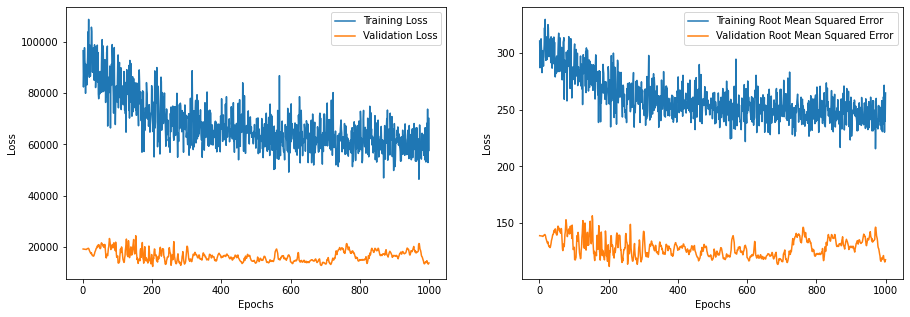

In [222]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Amazon

In [223]:
AMZN_prediction = AMZN_Model.predict(AMZN_Test_X)

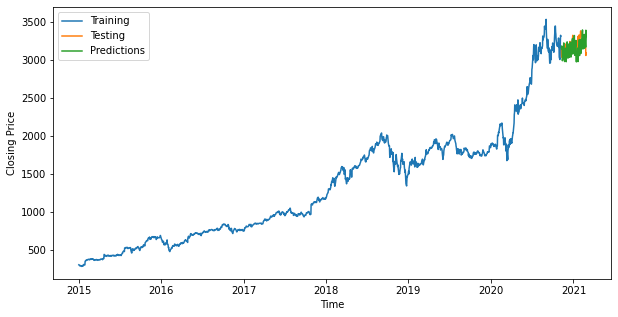

In [224]:
plt.figure(figsize=(10, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] < '2020-11-07'], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [225]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Y.reshape(-1, 5), AMZN_prediction))
mape = np.mean(np.abs(AMZN_prediction - AMZN_Test_Y.reshape(-1, 5))/np.abs(AMZN_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 117.43626659700189
MAPE: 0.02975440933705796
